## Maria Harrison
### CS 8395-51- Introduction to Quantum Computing
#### Final Project: Shor’s Algorithm, Bernstein-Vazirani, and Deutsch-Josza Algorithm: A Deep Dive

## SHOR'S ALGORITHM

#### Pseudocode
Shor's algorithm factors a prime product: 
1) Determine N: a number to be factorized, noted as `N`
2) Pick a random number between `1 and N`, noted as `k`
3) Find the GCD of `N` and `P` using Euclid's Algorithm\
    - If GCD = 1, go to step 4
    - If GCD != 1, STOP
4) Find the period of the function: let `r` be the smallest positive integer, that satifies the following:
    -  `f(x) = k^x mod N`
    - `f(a) = f(a + r)`
2) Find the period of the function: such that `p` is the smallest `p `such `a^r = 1 (mod N)` i.e the period of the function .
 
3) If `r` is odd go back to step 1

4) If `a^r/2 + 1 = 0 (mod N)` go back to step 1

5) Let `{p, q} = { gcd(a^r/2 - 1, N),  gcd(a^r/2+1, N) }`


In [1]:
# Imports
from qiskit import QuantumCircuit, Aer, assemble, execute,transpile
from qiskit.circuit.library import QFT
import numpy as np
from math import gcd
from fractions import Fraction

In [2]:

def quPhaseEstCircuit(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for i in range(x): 
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, x)
    c_U = U.control()
    return c_U


In [3]:
def modular_exponentiation(given_circuit, n, m, a):
    for x in range(n):
        exponent = 2**x
        given_circuit.append(quPhaseEstCircuit(a, exponent), 
                     [x] + list(range(n, n+m)))

In [4]:
"""
    params
        a: guess for factor of 15
        n: measurements count
        m: numbe of target qubits

    return
        quantum_gate, quantum_circuit
"""

def oracle(a,n,m):
    shor = QuantumCircuit(n+m, n)
    
    # initialize first n qubits with h gate
    shor.h(range(n))
    
    # applying sigma x gate to last qubity
    shor.x(n+m-1)
    shor.barrier()
    
    # apply moduluos exponentation to last 
    modular_exponentiation(shor, n, m, a)
    shor.barrier()
    
    #apply qft inverse
    shor.append(QFT(n, do_swaps=False).inverse(), range(n))
    
    # measure the first n qubits
    shor.measure(range(n), range(n))
    
    return shor

/opt/homebrew/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


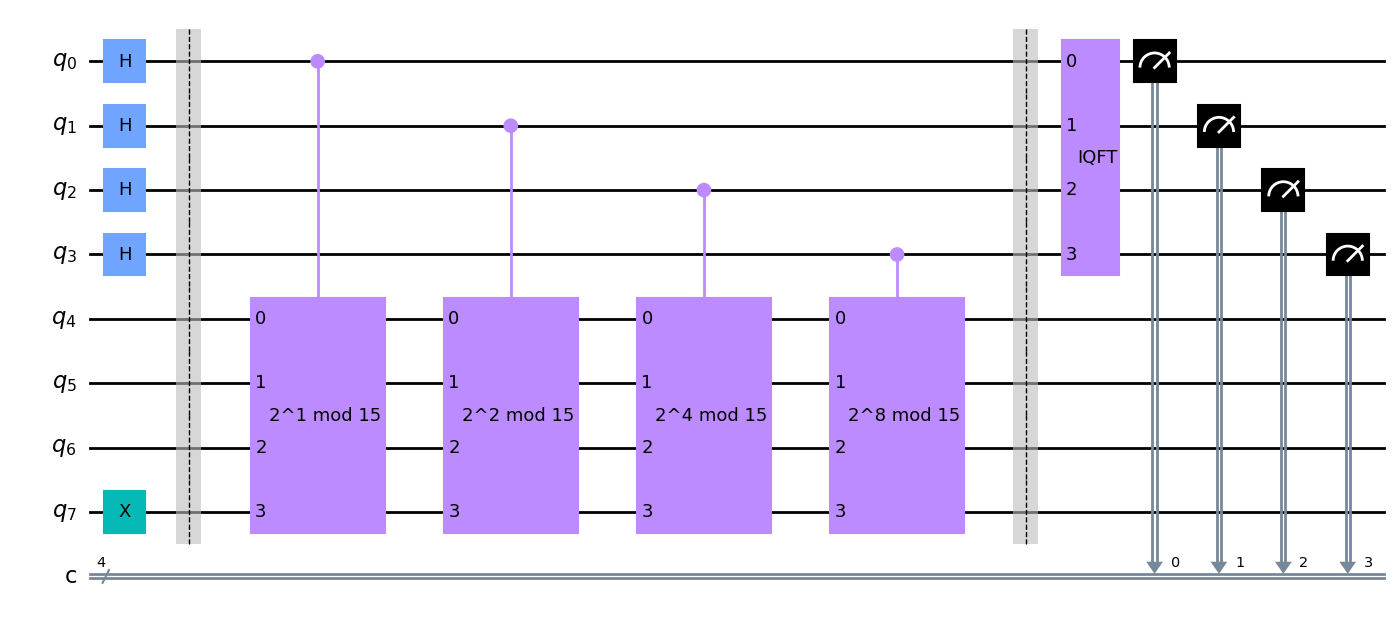

In [5]:
n = 4; m = 4; a = 2
shorsCircuit = oracle(a,n,m)
shorsCircuit.draw('mpl')

In [6]:
# Defining the simulator:
backend = Aer.get_backend('qasm_simulator') 

def shors(N=15, backend=backend):
    found_factors = False
    n = len(bin(N))-2
    m = n
    valid_a = [2,7,8,11,13]
    
    while found_factors == False:
        # STEP 1: Choose a randomly in valid a's
        if len(valid_a)==0:
            break
        a = np.random.choice(valid_a)
        print(f"Trying a = {a}")

        r = 1 
        
        # STEP 2: Find period r
        while a**r%N != 1: 
            #Defining Shor's Circuits (QPE):
            qc = oracle(a,n,m) 
            #measure
            measure = execute(qc, backend=backend, shots=1,memory=True).result().get_memory()[0]
            #convert to decimal
            measure = int(measure,2)
            phase = measure/(2**(n-1))
            # step 2.2: Find denominator r (Continued fraction algorithm)
            r = Fraction(phase).limit_denominator(N).denominator
            
        # step 3 qnd 4  check if r is even and a^(r/2) != -1 (mod N)
        if r%2==0 and (a**(r/2)+1)%N!=0:
            #step 5 compute factors
            factors = [gcd(a**(r//2)-1,N),gcd(a**(r//2)+1,N)]
            print(f" --- order r = {r}")
            if factors[0] not in [1,N]: 
                found_factors = True
                print(f" --- Sucessfully found factors {factors}")
            else:
                print(f" --- Trivial factors found: [1,15]")
        if found_factors == False:
            print(f" --- a={a} failed!")
        valid_a.remove(a)
shors()

Trying a = 11
 --- order r = 8
 --- Trivial factors found: [1,15]
 --- a=11 failed!
Trying a = 8
 --- order r = 4
 --- Sucessfully found factors [3, 5]
